<a href="https://colab.research.google.com/github/pmadhyastha/INM434/blob/main/positional_encodings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Positional Encoding in Transformers

This notebook aims to build intuition for the sinusoidal Positional Encoding (PE) technique used in Transformer models, as described in the "Attention Is All You Need" paper.

## Background (from user request)

Positional encoding adds a time signal to the input embeddings. This is necessary because unlike RNNs, there is no recurrence built into transformers which carries positional information in the network architecture itself. Input embeddings for the same token would be identical regardless of their position without PE.

Simple ideas like numbering positions (1, 2, 3...) or scaling positions to [0, 1] have drawbacks:
*   Absolute numbering might not scale well and differences might not be meaningful.
*   Scaled numbering ([0,1]) makes the distance between steps variable depending on sequence length.

### Ideal Criteria for Positional Encoding:
1.  Output a unique encoding for each time-step (position).
2.  The distance between any two time-steps should be consistent across sequences of different lengths.
3.  The model should generalize to longer sequences than seen during training.
4.  Values should be bounded.
5.  It must be deterministic (not learned).

### The Sinusoidal Approach

The paper proposes using sine and cosine functions of different frequencies:

- $PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})$

and

- $PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})$

Where:
*   `pos` is the position of the token in the sequence (0, 1, ..., max_len-1).
*   `i` is the dimension index (0, 1, ..., d_model/2 - 1).
*   `d_model` is the embedding dimension.

This PE vector is added to the input embedding vector.

### Intuition & Properties

*   **Clock Hand Analogy:** Think of each dimension pair (2i, 2i+1) as a clock hand rotating at a specific frequency. Lower dimensions (small `i`) rotate slowly (long wavelength), higher dimensions rotate quickly (short wavelength). The combination of these rotations gives each position a unique signature.
*   **Relative Position:** For any fixed offset `k`, $PE_{pos+k}$ can be represented as a linear function (specifically, a rotation) of $PE_{pos}$. This makes it easy for the model to learn relative attention.
*   **Distance:** The dot product similarity between $PE_{pos}$ and $PE_{pos+k}$ depends primarily on the offset `k`, decaying as `k` increases.

Let's visualize these properties.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D # For custom legends

# Set a nice plotting style
plt.style.use('seaborn-v0_8-darkgrid')
# Ensure plots appear inline in the notebook
%matplotlib inline
# Make plots higher resolution
plt.rcParams['figure.dpi'] = 100

In [4]:
def get_positional_encoding(max_len, d_model):
    """
    Generates the sinusoidal positional encoding matrix.

    Args:
        max_len (int): Maximum sequence length.
        d_model (int): Embedding dimension.

    Returns:
        np.ndarray: Positional encoding matrix of shape (max_len, d_model)
    """
    # Warning if d_model is odd, as pairing works best with even dimensions.
    # The formula naturally pairs sin/cos for 2i and 2i+1.
    if d_model % 2 != 0:
        print(f"Warning: d_model ({d_model}) is odd. Sin/Cos pairing might be slightly uneven.")
        # Alternative: could pad d_model or handle the last dimension separately.
        # For simplicity here, we proceed but the last dimension might use sin/cos based on rounding.

    pe = np.zeros((max_len, d_model))
    position = np.arange(0, max_len, dtype=np.float32).reshape(-1, 1) # shape (max_len, 1)

    # Calculate the division term: 1 / (10000^(2i / d_model))
    # Using log form for numerical stability: exp(- (2i / d_model) * log(10000))
    # We calculate this for indices i = 0, 1, ..., floor(d_model/2) - 1
    div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * \
                      (-math.log(10000.0) / d_model)) # shape roughly (d_model/2,)

    # Apply sin to even indices (0, 2, 4, ...)
    pe[:, 0::2] = np.sin(position * div_term)

    # Apply cos to odd indices (1, 3, 5, ...)
    # Ensure we don't go out of bounds if d_model is odd
    pe[:, 1::2] = np.cos(position * div_term[:pe[:, 1::2].shape[1]]) # Match shape for odd d_model

    return pe

Define the maximum sequence length and the embedding dimension for our visualization. Then, generate the PE matrix.


In [5]:
MAX_LEN = 100  # Maximum sequence length
D_MODEL = 64   # Embedding dimension (should be reasonably sized for visualization)

# --- Generate Positional Encoding ---
pe_matrix = get_positional_encoding(MAX_LEN, D_MODEL)

Let's visualize the entire PE matrix. Each row is a position, each column is a dimension in the encoding vector.

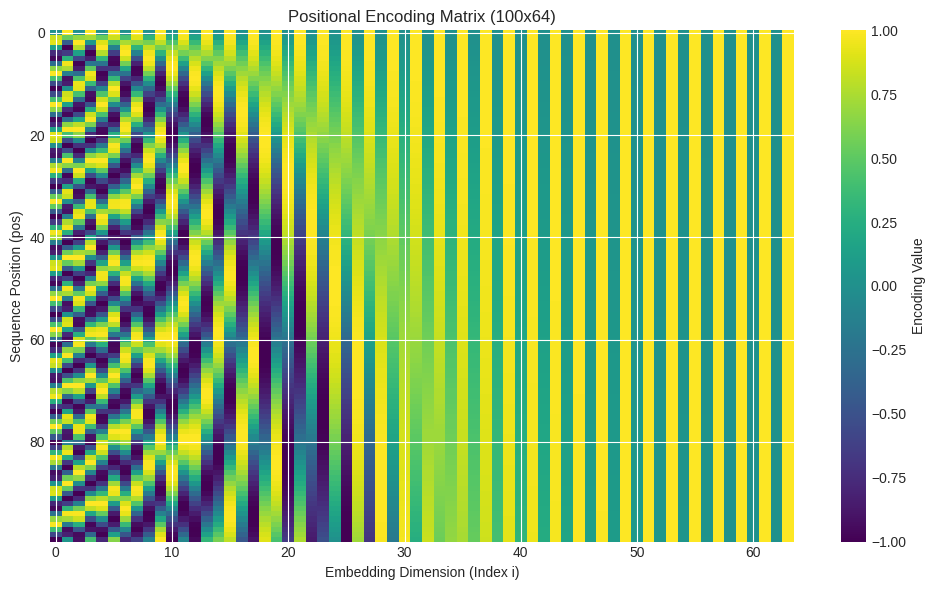

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(pe_matrix, cmap='viridis', aspect='auto', interpolation='nearest')
plt.xlabel("Embedding Dimension (Index i)")
plt.ylabel("Sequence Position (pos)")
plt.title(f"Positional Encoding Matrix ({MAX_LEN}x{D_MODEL})")
plt.colorbar(label="Encoding Value")
plt.tight_layout()
plt.show()

### Heatmap Interpretation
*   Each **row** represents the positional encoding vector for a specific position in the sequence (0 to `MAX_LEN-1`).
*   Each **column** represents a dimension within the embedding space (0 to `D_MODEL-1`).
*   You can clearly see the **sinusoidal patterns** varying across dimensions.
*   **Lower dimensions** (left side, small `i`) have **longer wavelengths** (slower frequencies). The values change slowly as the position increases.
*   **Higher dimensions** (right side, large `i`) have **shorter wavelengths** (higher frequencies). The values change rapidly as the position increases.
*   This combination of frequencies provides a **unique signature** for each position.

Let's plot the encoding value for a few selected dimensions across all sequence positions. This highlights the different frequencies.

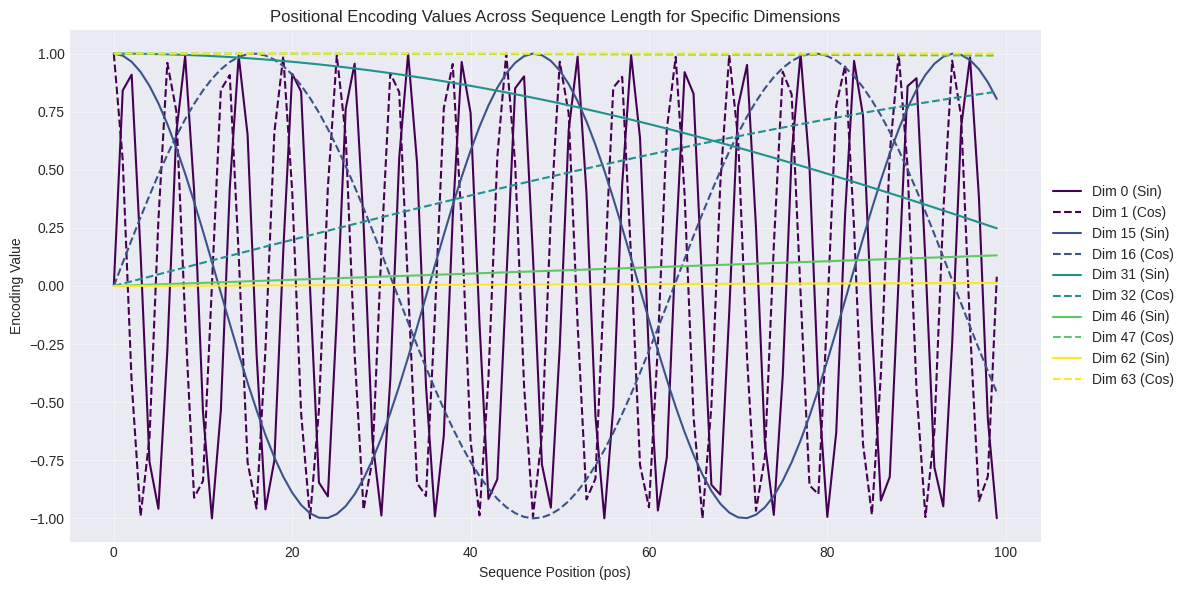

In [7]:
plt.figure(figsize=(12, 6))
num_curves_to_plot = 5
# Pick evenly spaced *pairs* of dimensions (i.e., starting with even indices)
dimensions_to_plot = np.linspace(0, D_MODEL - 2, num_curves_to_plot, dtype=int)

colors = plt.cm.viridis(np.linspace(0, 1, num_curves_to_plot))

for i, dim_start in enumerate(dimensions_to_plot):
    # Plot sin component (even index)
    plt.plot(pe_matrix[:, dim_start], label=f'Dim {dim_start} (Sin)', color=colors[i], linestyle='-')
    # Plot cos component (odd index)
    if dim_start + 1 < D_MODEL: # Ensure the odd index exists
      plt.plot(pe_matrix[:, dim_start + 1], label=f'Dim {dim_start+1} (Cos)', color=colors[i], linestyle='--')

plt.xlabel("Sequence Position (pos)")
plt.ylabel("Encoding Value")
plt.title("Positional Encoding Values Across Sequence Length for Specific Dimensions")
# Place legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


*   This plot shows the value of specific dimensions of the PE vector as the `pos` (sequence position) changes.
*   Each pair of solid (sine) and dashed (cosine) lines of the same color represents the pair $PE_{(pos, 2i)}$ and $PE_{(pos, 2i+1)}$ for a given `i` (determined by `dim_start`).
*   Dimensions with **lower indices** (e.g., Dim 0, 1 - darker colors) oscillate **slowly** across the sequence length (long wavelength).
*   Dimensions with **higher indices** (e.g., Dim ~30, 31 - lighter colors) oscillate **rapidly** (short wavelength).
*   The combination of these different frequency sinusoids helps make the encoding for each position unique.
*   The values are inherently **bounded** between -1 and 1.


How similar are the encoding vectors for different positions? We can measure this using the dot product. $Similarity(pos_1, pos_2) = PE_{pos_1} \cdot PE_{pos_2}$. This is related to attention, as the dot product is a key part of attention score calculation.


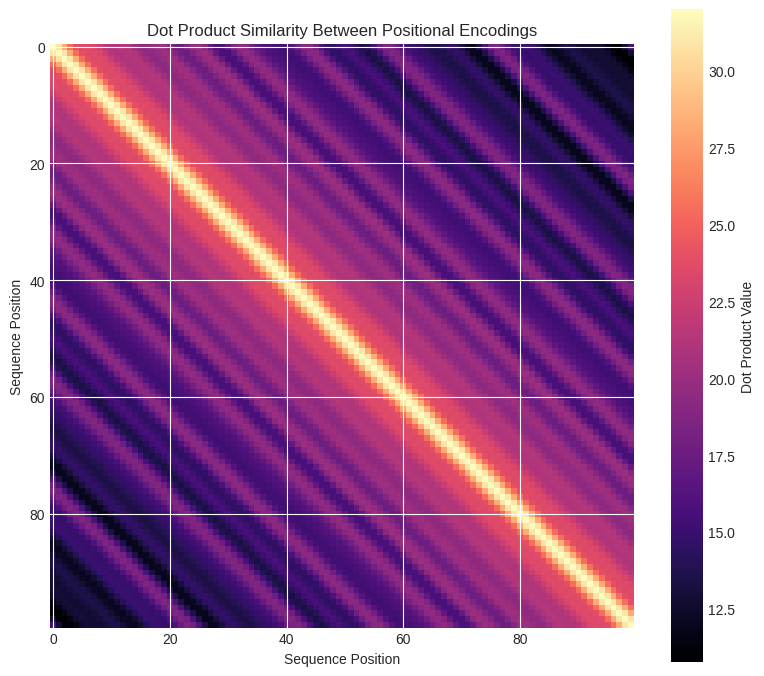

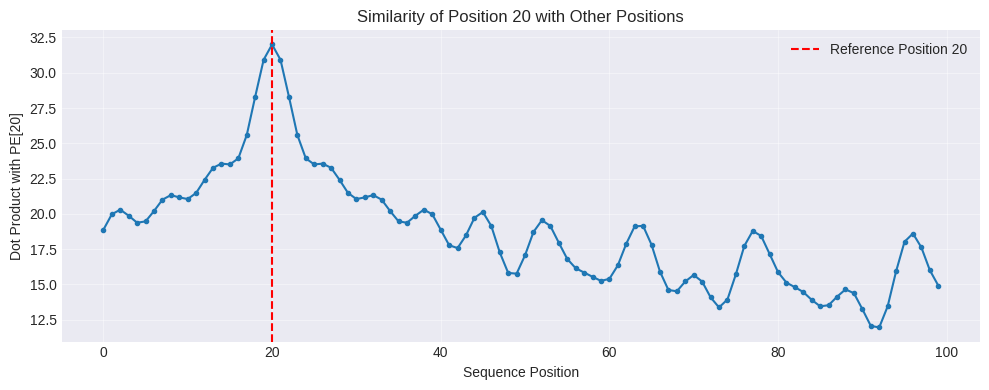

In [8]:
similarity_matrix = pe_matrix @ pe_matrix.T

plt.figure(figsize=(8, 7))
plt.imshow(similarity_matrix, cmap='magma', aspect='equal', interpolation='nearest')
plt.xlabel("Sequence Position")
plt.ylabel("Sequence Position")
plt.title("Dot Product Similarity Between Positional Encodings")
plt.colorbar(label="Dot Product Value")
plt.tight_layout()
plt.show()

# Plot similarity for a specific reference position (e.g., position 20)
pos_to_compare = MAX_LEN // 5 # Choose a position relative to max_len
if pos_to_compare >= MAX_LEN: pos_to_compare = MAX_LEN -1

plt.figure(figsize=(10, 4))
plt.plot(similarity_matrix[pos_to_compare, :], marker='.', linestyle='-')
plt.xlabel("Sequence Position")
plt.ylabel(f"Dot Product with PE[{pos_to_compare}]")
plt.title(f"Similarity of Position {pos_to_compare} with Other Positions")
# Highlight the reference position
plt.axvline(pos_to_compare, color='r', linestyle='--', label=f'Reference Position {pos_to_compare}')
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


*   The **heatmap** shows the dot product (similarity) between the PE vectors of every pair of positions.
*   The **main diagonal** is brightest because a vector's dot product with itself is maximized (equal to its squared L2 norm).
*   The pattern shows that **nearby positions have higher similarity** (brighter colors near the diagonal).
*   Similarity generally **decays** as positions get further apart.
*   Crucially, the pattern exhibits a **relative structure**. Notice the repeating bands parallel to the main diagonal. This indicates that the similarity between position `p` and `p+k` depends primarily on the **offset `k`**, not significantly on the absolute position `p`. This property is vital for the model to learn **relative positional attention**.
*   The **line plot** confirms this for a single reference position (`pos_to_compare`): similarity peaks at the position itself and decays, roughly symmetrically, around it. The local oscillations reflect the contributions of the different sinusoidal frequencies.


We can visualize the `(cos, sin)` pairs for a given position and dimension `i` as coordinates on a 2D plane. This helps build the intuition of rotating "clock hands".

*   $x = PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})$
*   $y = PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})$

Each point `(x, y)` lies on the unit circle. Let's plot these points for a few positions and a few dimension pairs (frequencies).



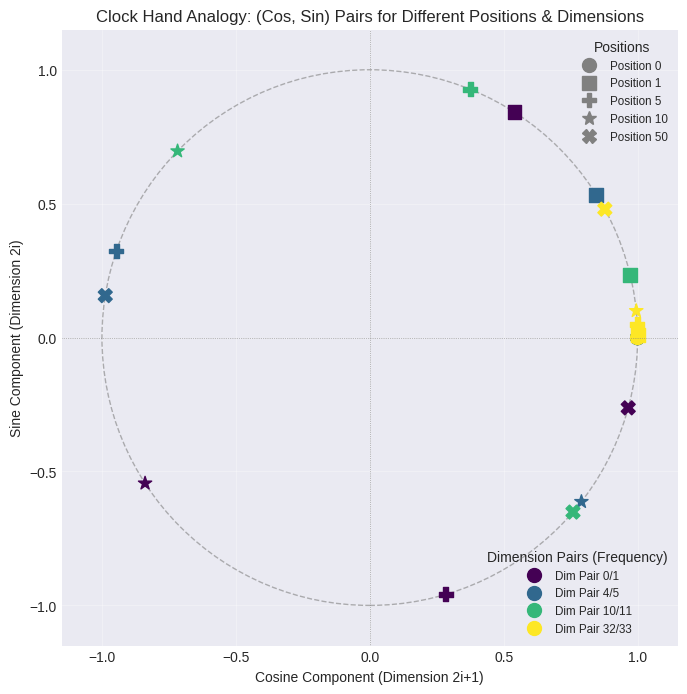

In [9]:
positions_to_plot = [0, 1, 5, 10, MAX_LEN // 2]
# Select a few dimension pairs (indices 'i' corresponding to 2i, 2i+1)
# Choose indices i = 0, 2, 5, d_model/4 (approx)
dim_indices_i = [0, 2, 5, D_MODEL // 4]
# Corresponding actual dimension starts (2*i)
dim_pairs_start_indices = [2*i for i in dim_indices_i]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111) # Standard cartesian plot

# Draw unit circle for reference
circle = plt.Circle((0, 0), 1, fill=False, color='grey', linestyle='--', alpha=0.6)
ax.add_patch(circle)

markers = ['o', 's', 'P', '*', 'X', 'D'] # Different marker for each position
colors = plt.cm.viridis(np.linspace(0, 1, len(dim_pairs_start_indices))) # Different color for each frequency/dim_pair

for i, pos in enumerate(positions_to_plot):
    pe_vector = pe_matrix[pos, :]
    points_x = []
    points_y = []
    point_colors = []

    for j, dim_start in enumerate(dim_pairs_start_indices):
        # Ensure the cosine dimension (dim_start + 1) exists
        if dim_start + 1 < D_MODEL:
            # x = cos component (odd index)
            x_coord = pe_vector[dim_start + 1]
            # y = sin component (even index)
            y_coord = pe_vector[dim_start]
            points_x.append(x_coord)
            points_y.append(y_coord)
            point_colors.append(colors[j])

    # Plot all (cos, sin) points for this position
    # Use color to denote the dimension pair (frequency) and marker for position
    scatter = ax.scatter(points_x, points_y, marker=markers[i % len(markers)], s=100,
                         c=colors, # Color by dimension pair index
                         label=f'Position {pos}' if i < 5 else None) # Avoid too many labels


ax.set_xlim(-1.15, 1.15)
ax.set_ylim(-1.15, 1.15)
ax.set_aspect('equal', adjustable='box')
ax.axhline(0, color='grey', lw=0.5, linestyle=':')
ax.axvline(0, color='grey', lw=0.5, linestyle=':')
ax.set_xlabel("Cosine Component (Dimension 2i+1)")
ax.set_ylabel("Sine Component (Dimension 2i)")
plt.title("Clock Hand Analogy: (Cos, Sin) Pairs for Different Positions & Dimensions")

# Create custom legends because scatter doesn't handle marker/color combos well directly
position_legend = [Line2D([0], [0], marker=markers[i % len(markers)], color='grey', label=f'Position {pos}',
                          linestyle='None', markersize=10)
                   for i, pos in enumerate(positions_to_plot)]
dim_legend = [Line2D([0], [0], marker='o', color=colors[j],
                     label=f'Dim Pair {dim_start}/{dim_start+1}', linestyle='None', markersize=10)
              for j, dim_start in enumerate(dim_pairs_start_indices)]

# Add legends to the plot
leg1 = ax.legend(handles=position_legend, loc='upper right', title="Positions", fontsize='small')
ax.add_artist(leg1) # Need this to display both legends
ax.legend(handles=dim_legend, loc='lower right', title="Dimension Pairs (Frequency)", fontsize='small')

plt.grid(True, alpha=0.3)
plt.show()

*   This plot shows pairs of `(cosine, sine)` values from the PE vector for selected positions and dimension pairs. Each point corresponds to `(PE[pos, 2i+1], PE[pos, 2i])`.
*   Each point lies on (or very close to) the **unit circle** because $\sin^2(\theta) + \cos^2(\theta) = 1$.
*   **Different markers** represent different sequence **positions** (e.g., `pos=0`, `pos=1`, `pos=5`...).
*   **Different colors** represent different **dimension pairs** (e.g., Dim 0/1, Dim 4/5...). These correspond to different **frequencies** or wavelengths from the `div_term`. Darker colors (lower `i`) are lower frequencies (slower clocks), lighter colors (higher `i`) are higher frequencies (faster clocks).
*   For a **fixed dimension pair (fixed color)**: As the position increases (change marker), the point **rotates** around the circle. The angle of rotation from `pos` to `pos+1` is constant for this frequency ($1 / 10000^{2i / d_{model}}$ radians). This constant rotation for a fixed offset `k` is the basis for easily representing relative positions linearly.
*   For a **fixed position (fixed marker)**: The different colored points show the different "phases" or "angles" on the clocks of different frequencies, all corresponding to that single position. This unique combination of angles across dimensions encodes the position.